In [1]:
# ECE661 HW6
# Zhengxin Jiang
# jiang839

import cv2
import numpy as np
import matplotlib . pyplot as plt
import math


# Calculate the otsu segmentation threshold
def otsuThreshold(image, n_iter, maskInv):
    
    mask_iter = np.ones(image.shape)

    # go for n iterations
    for it in range(n_iter):
        iter_img = image[np.nonzero(mask_iter)]
        
        hist, bin_edges = np.histogram(iter_img, bins=np.amax(iter_img)-np.amin(iter_img)+1)

        # Turn bin edges into centers
        bin_cent = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Get the probabilities for all thresholds
        w1 = np.cumsum(hist)
        w2 = np.cumsum(hist[::-1])
        w2 = w2[::-1]

        # Get the mean of two classes
        m1 = np.cumsum(hist * bin_cent) / w1
        m2 = (np.cumsum((hist * bin_cent)[::-1]) / w2[::-1])
        m2 = m2[::-1]

        # Get the between-class variance
        bc_var = w1 * w2 * (m1 - m2) ** 2

        # Maximize the inter_class_variance function val
        idx_maxvar = np.argmax(bc_var)
        threshold = bin_edges[idx_maxvar]
        
        if maskInv:
            mask_iter = image<threshold
        else:
            mask_iter = image>threshold
    
    return threshold


# otsu based on texture-based features
def texture_otsu(image, window_size, n_iter, maskInv):

    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    tex_img = np.zeros((image.shape[0],image.shape[1],len(window_size)))
    
    # get textures for all window sizes
    for i in range(len(window_size)):
        
        wwidth = window_size[i]//2
        
        # apply the window on the image
        for h in range(wwidth, img.shape[0]-wwidth):
            for w in range(wwidth, img.shape[1]-wwidth):
                tex_img[h,w,i] = np.var(img[h-wwidth:h+wwidth+1, w-wwidth:w+wwidth+1])
                
    tex_img = tex_img.astype(np.uint8)           
    
    result = rbg_otsu(tex_img, n_iter, maskInv)

    return result


# otsu based on rgb channels
def rbg_otsu(image, n_iter, maskInv):
    
    rgb = cv2.split(image)
    mask_rgb = []

    # obtain segmentations for three channels
    for i in range(len(rgb)):
        img = rgb[i]
        threshold = otsuThreshold(img, n_iter, maskInv)
        
        if maskInv:
            _,mask_=cv2.threshold(img,threshold,255,cv2.THRESH_BINARY_INV)
        else:
            _,mask_=cv2.threshold(img,threshold,255,cv2.THRESH_BINARY)

        mask_rgb.append(mask_)

    # take and oprtations on masks or or oprations on inverse masks
    # mask = mask_rgb[0]&mask_rgb[1]&mask_rgb[2]
    mask = mask_rgb[0]|mask_rgb[1]|mask_rgb[2]

    result = cv2.merge((mask,mask,mask))
    
    return result


# get contour from a mask image
# dilate-erode may applied for hole removing
def contour(image, dilate_erode_iters):
    
    img = image.copy()
    
    # apply dilation and erosion to remove holes
    if dilate_erode_iters > 0:
        kernel = np.ones((3, 3), np.uint8)
 
        img = cv2.dilate(img, kernel, iterations=dilate_erode_iters)
        img = cv2.erode(img, kernel, iterations=dilate_erode_iters)
        
    img_cont = img.copy()
    
    # change the non-contour light pixels to 0
    for h in range(1, img_cont.shape[0]-1):
        for w in range(1, img_cont.shape[1]-1):
            
            if img[h,w,0] == 255 and np.min(img[h-1:h+2, w-1:w+2]) == 255:
                img_cont[h,w] = [0,0,0]
                
    return img_cont
                
    


In [42]:
if __name__ == '__main__' :
    
    result_path = 'C:/Users/jzx/OneDrive - purdue.edu/ECE661/hw6/result images/'
    
    # load images
    img_car = cv2.imread('HW6-Images/car.jpg')
    img_cat = cv2.imread('HW6-Images/cat.jpg')
    img_dog = cv2.imread('HW6-Images/dog.jpeg')
    img_xbox = cv2.imread('HW6-Images/ct.jpg')
    
    
    ### Task 1.1 ###
    car_rgb = rbg_otsu(img_car, 2, True)
    cat_rgb = rbg_otsu(img_cat, 2, True)
    
    cv2.imwrite(result_path + 'carrgb' + '.jpg', car_rgb)
    cv2.imwrite(result_path + 'catrgb' + '.jpg', cat_rgb)
    
    plt.figure()
    plt.imshow(car_rgb)
    plt.figure()
    plt.imshow(cat_rgb)

    ### Task 1.2 ###
    car_tex = texture_otsu(img_car, [3,5,7], 2, False)
    cat_tex = texture_otsu(img_cat, [3,5,7], 1, False)

    plt.figure()
    plt.imshow(car_tex)
    plt.figure()
    plt.imshow(cat_tex)
    
#     cv2.imwrite(result_path + 'cartex' + '.jpg', car_tex)
#     cv2.imwrite(result_path + 'cattex' + '.jpg', cat_tex)
    
    ### Task 1.3 ###
    cat_tex_ct = contour(cat_tex, 2)
    cat_rgb_ct = contour(cat_rgb, 1)
    
    plt.figure()
    plt.imshow(cat_tex_ct)
    plt.figure()
    plt.imshow(cat_rgb_ct)
    
    car_tex_ct = contour(car_tex, 1)
    car_rgb_ct = contour(car_rgb, 0)
    
    plt.figure()
    plt.imshow(car_tex_ct)
    plt.figure()
    plt.imshow(car_rgb_ct)

#     cv2.imwrite(result_path + 'carrgbct' + '.jpg', car_rgb_ct)
#     cv2.imwrite(result_path + 'cartexct' + '.jpg', car_tex_ct)
#     cv2.imwrite(result_path + 'catrgbct' + '.jpg', cat_rgb_ct)
#     cv2.imwrite(result_path + 'cattexct' + '.jpg', cat_tex_ct)


    ### Self Images ###
#     dog_rgb = rbg_otsu(img_dog, 2, False)
#     plt.figure()
#     plt.imshow(dog_rgb)
    
#     dog_tex = texture_otsu(img_dog, [3,5,7], 1, True)
#     plt.figure()
#     plt.imshow(dog_tex)
    
#     kernel = np.ones((3, 3), np.uint8) 
#     dog_tex = cv2.erode(dog_tex, kernel, iterations=3)
#     dog_tex = cv2.dilate(dog_tex, kernel, iterations=3)
    
#     dog_tex_ct = contour(dog_tex, 0)
#     dog_rgb_ct = contour(dog_rgb, 1)
    
#     plt.figure()
#     plt.imshow(dog_tex_ct)
#     plt.figure()
#     plt.imshow(dog_rgb_ct)
    
#     cv2.imwrite(result_path + 'dogrgb' + '.jpg', dog_rgb)
#     cv2.imwrite(result_path + 'dogtex' + '.jpg', dog_tex)
#     cv2.imwrite(result_path + 'dogrgbct' + '.jpg', dog_rgb_ct)
#     cv2.imwrite(result_path + 'dogtexct' + '.jpg', dog_tex_ct)


#     xbox_rgb = rbg_otsu(img_xbox, 2, True)
#     plt.figure()
#     plt.imshow(xbox_rgb)
    
#     xbox_tex = texture_otsu(img_xbox, [3,5,7], 1, False)
#     plt.figure()
#     plt.imshow(xbox_tex)
    
    
#     xbox_rgb_ct = contour(xbox_rgb, 0)
#     xbox_tex_ct = contour(xbox_tex, 1)
    
#     plt.figure()
#     plt.imshow(xbox_tex_ct)
#     plt.figure()
#     plt.imshow(xbox_rgb_ct)

#     cv2.imwrite(result_path + 'xboxrgb' + '.jpg', xbox_rgb)
#     cv2.imwrite(result_path + 'xboxtex' + '.jpg', xbox_tex)
#     cv2.imwrite(result_path + 'xboxrgbct' + '.jpg', xbox_rgb_ct)
#     cv2.imwrite(result_path + 'xboxtexct' + '.jpg', xbox_tex_ct)
    
    

In [69]:
rgb = cv2.split(img_car)
otsuThreshold(rgb[0], 1, False)

(233,)
(234,)


97.5793991416309

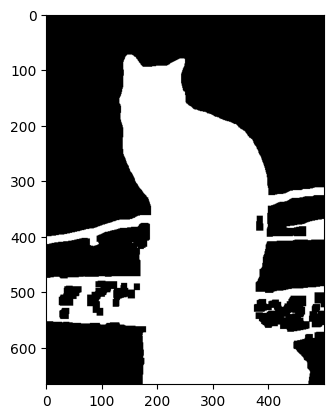

In [102]:
kernel = np.ones((3, 3), np.uint8)
 
img_d = cv2.dilate(cat_tex, kernel, iterations=5)
img_erosion = cv2.erode(img_d, kernel, iterations=5)

plt.figure()
plt.imshow(img_erosion)